In [14]:
from __future__ import absolute_import, unicode_literals
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import shutil
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def weight_variable(name,shape):
  initializer=tf.contrib.layers.xavier_initializer_conv2d()
  return tf.get_variable(name,shape,initializer=initializer)

def bias_variable(shape,name,initial=0.1):
  initializer = tf.constant_initializer(initial)
  return tf.get_variable(initializer=initializer,name=name,shape=shape)

def conv2d(x, W,padding,name):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding=padding,name=name)

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [16]:
# Get the training and test data
mnist = input_data.read_data_sets("data/", one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


(55000, 10)


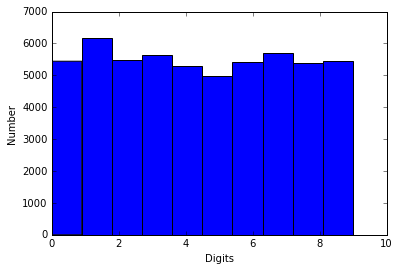

In [17]:
#Getting Training data statistics 
train_labels = mnist.train.labels
test_labels = mnist.test.labels
print train_labels.shape
train_data = np.argmax(train_labels,1)
test_data = np.argmax(test_labels,1)
df1 = pd.Series(train_data)
df1.plot(kind="hist")
plt.xlabel("Digits")
plt.ylabel("Number")
plt.show()


(10000, 10)


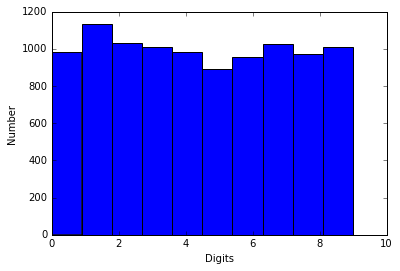

In [18]:
#Getting test data statistics 
print test_labels.shape
df2 = pd.Series(test_data)
df2.plot(kind="hist")
plt.xlabel("Digits")
plt.ylabel("Number")
plt.show()

In [7]:
#Describing the convolutional neural network in a compact way. 
#Dropout layer right after the 2nd conv layer
model_params = {
                    'conv_network' : [('SAME',16),('SAME',32)],
                    'conv_weights' : [(1,32),(32,64)],
                    'pool_layers' : [0,1],
                    'drop_layers' : [1],
                    'fc_weight' : 1024
                    }

In [20]:
image_size = 28
test_size = 10
batch_size = 50
patch_size = 5
num_channels = 1
num_labels = 10


In [21]:
graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=[None, 784])
    tf_train_labels = tf.placeholder(tf.float32, shape=[None, 10])
    tf_test_dataset = tf.placeholder(tf.float32, shape=(test_size, image_size, image_size, num_channels))
    keep_prob = tf.placeholder("float")
    
    # Variables.
    W_conv = []
    b_conv = []
    W_fc = []
    b_fc = []
    for i,filt_param in enumerate(model_params['conv_weights']) :
        W_conv.append(weight_variable('Wconv{}'.format(i),[patch_size, patch_size, filt_param[0],filt_param[1]]))
        b_conv.append(bias_variable(shape=[filt_param[1]],name='Bconv{}'.format(i),initial=1.0))  

    def model(data,keep_prob,shape) :
        conv = data
        for i,params in enumerate(model_params['conv_network']) :
            pool_layers = model_params['pool_layers']
            drop_layers = model_params['drop_layers']
            conv = conv2d(conv,W_conv[i],padding=params[0],name='Conv{}'.format(i)) 
            conv = tf.nn.relu(conv + b_conv[i])
            print "Conv shape", conv.get_shape()
            if i in drop_layers :
                conv = tf.nn.dropout(conv,keep_prob)
            if i in pool_layers :
                conv = max_pool_2x2(conv)
            print "End" ,conv.get_shape()
        
        shape = conv.get_shape().as_list()
        reshape = tf.reshape(conv, [-1, shape[1] * shape[2] * shape[3]])
        fc_depth = model_params['fc_weight']
        W_fc.append(weight_variable("Wfc{}".format(0),[shape[1] * shape[2] * shape[3],fc_depth])) 
        b_fc.append(bias_variable(initial=1.0,shape=[fc_depth],name='Bfc{}'.format(0)))
        out_fc1 = tf.nn.relu(tf.matmul(reshape, W_fc[0]) + b_fc[0])
        
        shape = out_fc1.get_shape().as_list()
        W_fc.append(weight_variable("Wfc{}".format(1),[fc_depth,num_labels])) 
        b_fc.append(bias_variable(initial=1.0,shape=[num_labels],name='Bfc{}'.format(1)))
        out = tf.nn.softmax(tf.matmul(out_fc1, W_fc[1]) + b_fc[1])
        return out
    
    y_model = model(tf.reshape(tf_train_dataset,[-1,image_size,image_size,num_channels]),keep_prob=keep_prob,shape=[batch_size,image_size,image_size,1])
    cross_entropy = -tf.reduce_sum(tf_train_labels * tf.log(y_model))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_model, 1), tf.argmax(tf_train_labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    sess = tf.Session()
    sess.run(tf.initialize_all_variables())
    
    for i in range(20000):
        batch = mnist.train.next_batch(batch_size)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(
                {tf_train_dataset: batch[0], tf_train_labels: batch[1], keep_prob: 1.0}, sess)
            print "step %d, training accuracy %g" % (i, train_accuracy)
        train_step.run(
            {tf_train_dataset: batch[0], tf_train_labels: batch[1], keep_prob: 0.5}, sess)

    print "test accuracy %g" % accuracy.eval(
        {tf_train_dataset: mnist.test.images, tf_train_labels: mnist.test.labels, keep_prob: 1.0}, sess)
    
    #Store the variables as constant to export the graph. To be integrated with the android app. 
    tf_train_dataset_2 = tf.placeholder(tf.float32, shape=[None, image_size,image_size, num_channels])
    W_conv_temp = []
    b_conv_temp = []
    W_fc_temp = []
    b_fc_temp = []
    
    for i,filt_param in enumerate(model_params['conv_weights']) :
        W_conv_temp.append(W_conv[i].eval(sess))
        b_conv_temp.append(b_conv[i].eval(sess))
    
    for i in range (0,2) :
        W_fc_temp.append(W_fc[i].eval(sess))
        b_fc_temp.append(b_fc[i].eval(sess))
        
    
    sess.close()
    

    

Conv shape (?, 28, 28, 32)
End (?, 14, 14, 32)
Conv shape (?, 14, 14, 64)
End (?, 7, 7, 64)
step 0, training accuracy 0.04
step 100, training accuracy 0.26
step 200, training accuracy 0.36
step 300, training accuracy 0.76
step 400, training accuracy 0.74
step 500, training accuracy 0.84
step 600, training accuracy 0.84
step 700, training accuracy 0.94
step 800, training accuracy 0.96
step 900, training accuracy 0.92
step 1000, training accuracy 0.86
step 1100, training accuracy 0.94
step 1200, training accuracy 0.94
step 1300, training accuracy 0.94
step 1400, training accuracy 0.9
step 1500, training accuracy 0.94
step 1600, training accuracy 0.96
step 1700, training accuracy 0.94
step 1800, training accuracy 0.96
step 1900, training accuracy 0.98
step 2000, training accuracy 0.96
step 2100, training accuracy 0.92
step 2200, training accuracy 0.94
step 2300, training accuracy 0.96
step 2400, training accuracy 0.96
step 2500, training accuracy 0.96
step 2600, training accuracy 0.96
ste

In [22]:
g = tf.Graph()
with g.as_default() :
    x_2 = tf.placeholder("float", shape=[None, 784], name="input")
    W_conv_const = []
    b_conv_const = []
    W_fc_const = []
    b_fc_const = []
    
    for i,filt_param in enumerate(model_params['conv_weights']) :
        W_conv_const.append(tf.constant(W_conv_temp[i]))
        b_conv_const.append(tf.constant(b_conv_temp[i]))
        
    for i in range (0,2) :
        W_fc_const.append(tf.constant(W_fc_temp[i]))
        b_fc_const.append(tf.constant(b_fc_temp[i]))
        
        
    def model(data,shape) :
        conv = data
        for i,params in enumerate(model_params['conv_network']) :
            pool_layers = model_params['pool_layers']
            drop_layers = model_params['drop_layers']
            conv = conv2d(conv,W_conv_const[i],padding=params[0],name='Conv{}'.format(i)) 
            conv = tf.nn.relu(conv + b_conv_const[i])
            print "Conv shape", conv.get_shape()
            if i in pool_layers :
                conv = max_pool_2x2(conv)
            print "End" ,conv.get_shape()
        
        shape = conv.get_shape().as_list()
        reshape = tf.reshape(conv, [-1, shape[1] * shape[2] * shape[3]])
        fc_depth = model_params['fc_weight']
        out_fc1 = tf.nn.relu(tf.matmul(reshape, W_fc_const[0]) + b_fc_const[0])
        
        shape = out_fc1.get_shape().as_list()
        W_fc.append(weight_variable("Wfc{}".format(1),[fc_depth,num_labels])) 
        b_fc.append(bias_variable(initial=1.0,shape=[num_labels],name='Bfc{}'.format(1)))
        out = tf.nn.softmax(tf.matmul(out_fc1, W_fc_const[1]) + b_fc_const[1],name="output")
        return out
    
    y_model_2 = model(tf.reshape(x_2,[-1,image_size,image_size,1]),shape=[batch_size,image_size,image_size,1])
    
    sess_2 = tf.Session()
    init_2 = tf.initialize_all_variables();
    sess_2.run(init_2)
    
    graph_def = g.as_graph_def()
    tf.train.write_graph(graph_def, ".", 'NumTrans_Graph.pb', as_text=False)
    
    # Test trained model
    y__2 = tf.placeholder("float", [None, 10])
    correct_prediction_2 = tf.equal(tf.argmax(y_model_2, 1), tf.argmax(y__2, 1))
    accuracy_2 = tf.reduce_mean(tf.cast(correct_prediction_2, "float"))

    #Confirm this matches with the one obtained before. 
    print "check accuracy %g" % accuracy_2.eval(
        {x_2: mnist.test.images, y__2: mnist.test.labels}, sess_2)
    
    
    
    
    

Conv shape (?, 28, 28, 32)
End (?, 14, 14, 32)
Conv shape (?, 14, 14, 64)
End (?, 7, 7, 64)
check accuracy 0.9905
